In [182]:
import os
import glob
import numpy as np

def read_tpetra_output(label, nx, ny, directory='.'):
    """
    Reads multiple Tpetra vector output files of the form 'label_<rank>.out'
    and returns a 2D NumPy array of shape (nx, ny).

    Parameters:
        label (str): The prefix label used in the file names (e.g., "rhs").
        nx (int): Number of grid points in x-direction.
        ny (int): Number of grid points in y-direction.
        directory (str): Directory where the files are located (default: current).

    Returns:
        np.ndarray: Assembled 2D array of shape (nx, ny).
    """
    data = np.zeros((nx, ny))

    # Find all matching files
    pattern = os.path.join(directory, f"{label}_*.out")
    files = glob.glob(pattern)

    if not files:
        raise FileNotFoundError(f"No files found with pattern: {pattern}")

    for filename in files:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip().strip('()')
                if not line:
                    continue
                i_str, j_str, val_str = line.split(',')
                i = int(i_str.strip())
                j = int(j_str.strip())
                value = float(val_str.strip())
                data[i, j] = value

    return data

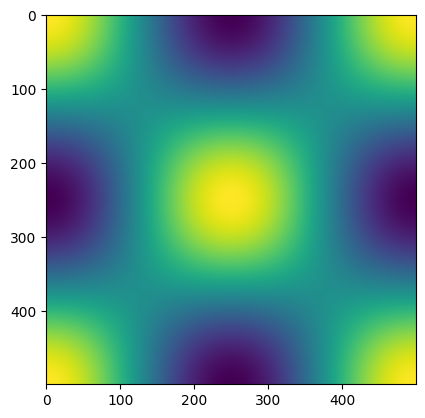

In [183]:
rhs_data = read_tpetra_output("../rhs", nx=500, ny=500)
imshow(rhs_data, cmap='viridis')

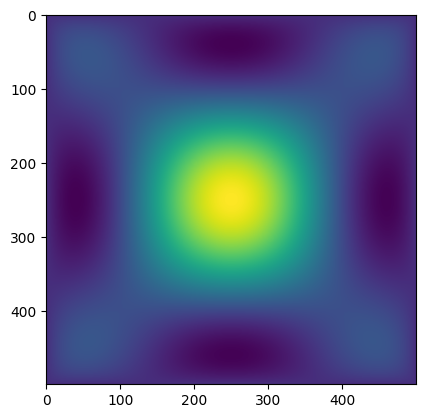

In [184]:
rhs_data = read_tpetra_output("../phi", nx=500, ny=500)
imshow(rhs_data, cmap='viridis')